Link to Google Notebook:
https://colab.research.google.com/drive/19zhygnx0iAEjIm8WyCvGPwfCAnCr8_Ev

In [1]:
pip install -i https://test.pypi.org/simple/ icalgosocdemo==0.0.8

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 645kB 3.5MB/s 


In [0]:
from icalgodemo.strategy import Strategy
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Week 2 Working with non stationary data


Example: S&P 500 in the last 15 years

In [0]:
class BuyandHoldStrategy(Strategy):

    def before_trades(self):
      return None 
    
    def ondata(self,bid,ask):
      return 1


In [4]:
strat = BuyandHoldStrategy(datasets='SPY')
strat.train()

Running Pedlar Demo for single asset. Dataset SPY


Training datasets can now be downloaded. Currently we support GBPUSD and SPY dataset

In [5]:
strat.download_train(dataset='SPY')

Training Data Downloaded from dataset SPY


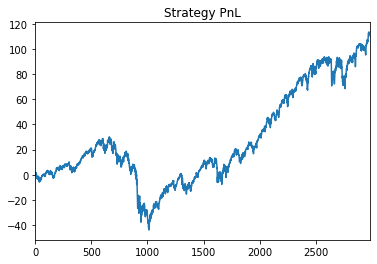

In [6]:
strat.plot_pnl()

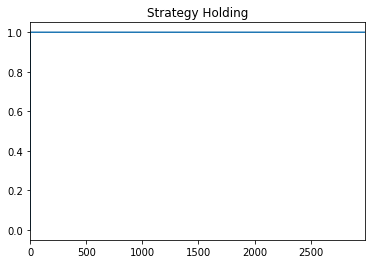

In [7]:
strat.plot_holding()

### MACD signal as in last week

In [0]:
class MACDStrategy(Strategy):

    def before_trades(self):
      self.bidhist = deque(maxlen=250)
      self.askhist = deque(maxlen=250)
      self.midhist = deque(maxlen=250)
      self.fast_length = 20
      self.slow_length = 50
      self.holdinghist = deque(maxlen=50)
      return None 
    
    def ondata(self,bid,ask):

      self.bidhist.append(bid)
      self.askhist.append(ask)
      mid = (ask+bid)/2
      self.midhist.append(mid)
      fast_mean = np.array(self.midhist)[-self.fast_length:].mean()
      slow_mean = np.array(self.midhist)[-self.slow_length:].mean()

      if fast_mean >= slow_mean:
        signal = 1
      else:
        signal = -1
      self.holdinghist.append(signal)

      # warmup for history 
      if len(self.midhist)>=50:
        return np.array(self.holdinghist).mean()
      else:
        return 0 


In [10]:
strat = MACDStrategy(datasets='SPY')
strat.train()

Running Pedlar Demo for single asset. Dataset SPY


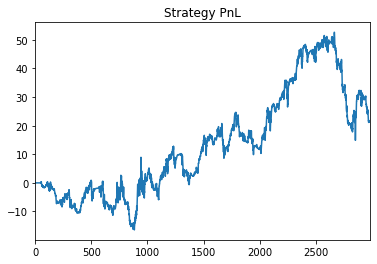

In [11]:
strat.plot_pnl()

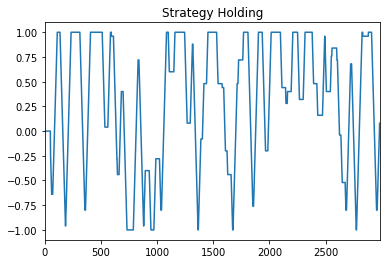

In [12]:
strat.plot_holding()

Question: Which strategy is better? What metrics would you use to compare different trading strategies? 

## Linear regression/ Autoregressive model 


Using the price data directly

In [0]:
whole_train_data = pd.read_csv('Train_SPY.csv',index_col=0)
whole_train_data.columns = ['Time','Bid','Ask']
whole_train_data['Mid'] = (whole_train_data['Bid'] + whole_train_data['Ask'])/2

In [0]:
for i in range(1,6):
  whole_train_data['Mid_{}'.format(i)] = whole_train_data['Mid'].shift(periods=i)

In [0]:
whole_train_data.dropna(inplace=True)

In [16]:
whole_train_data.head(5)

,Time,Bid,Ask,Mid,Mid_1,Mid_2,Mid_3,Mid_4,Mid_5
5,2005-03-04,102.465,102.475,102.47,101.19,101.15,101.20,100.68,101.36
6,2005-03-07,102.505,102.515,102.51,102.47,101.19,101.15,101.20,100.68
7,2005-03-08,102.105,102.115,102.11,102.51,102.47,101.19,101.15,101.20
8,2005-03-09,100.965,100.975,100.97,102.11,102.51,102.47,101.19,101.15
9,2005-03-10,101.195,101.205,101.20,100.97,102.11,102.51,102.47,101.19


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression

In [0]:
shifted_columns = ['Mid_{}'.format(i) for i in range(1,6)]
X = whole_train_data[shifted_columns]
X_train, X_test, y_train, y_test = train_test_split(X,whole_train_data['Mid'],test_size=0.2,random_state=0)

In [19]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test,y_test)

0.9986238203088182

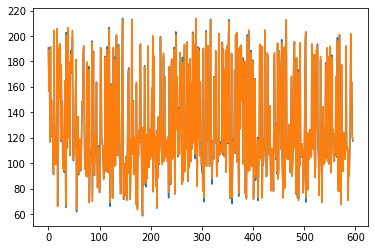

In [20]:
plt.plot(y_test.values)
plt.plot(y_pred)

Question: A near perfect score is obtained. Can this simple AR model use in real trading? How should we intepret this result?

Using log returns

In [0]:
whole_train_data = pd.read_csv('Train_SPY.csv',index_col=0)
whole_train_data.columns = ['Time','Bid','Ask']
whole_train_data['Mid'] = (whole_train_data['Bid'] + whole_train_data['Ask'])/2
whole_train_data['Return'] = np.log(whole_train_data['Mid']) - np.log(whole_train_data['Mid'].shift(1))

In [0]:
for i in range(1,6):
  whole_train_data['Return_{}'.format(i)] = np.log(whole_train_data['Mid'].shift(i)) - np.log(whole_train_data['Mid'].shift(i+1))

In [23]:
whole_train_data.dropna(inplace=True)
whole_train_data.head(5)

,Time,Bid,Ask,Mid,Return,Return_1,Return_2,Return_3,Return_4,Return_5
6,2005-03-07,102.505,102.515,102.51,0.000390,0.012570,0.000395,-0.000494,0.005152,-0.006731
7,2005-03-08,102.105,102.115,102.11,-0.003910,0.000390,0.012570,0.000395,-0.000494,0.005152
8,2005-03-09,100.965,100.975,100.97,-0.011227,-0.003910,0.000390,0.012570,0.000395,-0.000494
9,2005-03-10,101.195,101.205,101.20,0.002275,-0.011227,-0.003910,0.000390,0.012570,0.000395
10,2005-03-11,100.495,100.505,100.50,-0.006941,0.002275,-0.011227,-0.003910,0.000390,0.012570


In [0]:
shifted_columns = ['Return_{}'.format(i) for i in range(1,6)]
X = whole_train_data[shifted_columns]
X_train, X_test, y_train, y_test = train_test_split(X,whole_train_data['Return'],test_size=0.2,random_state=0)

In [25]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test,y_test)

-0.06496059207048743

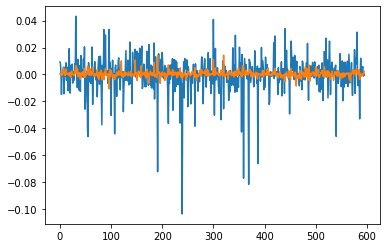

In [26]:
plt.plot(y_test.values)
plt.plot(y_pred)

Question: AR model fails to predict the return of SPY. Given the same amount of information is contained in the price and return series, what can be concluded for forecasting in financial time series? 